In [11]:
#from __future__ import unicode_literals, absolute_import
import os
import sys

sys.path.insert(0,'/global/common/software/lsst/common/miniconda/py3-4.2.12/lib/python3.6/site-packages')
sys.path.insert(0,'/global/common/software/lsst/common/miniconda/py3-4.2.12/bin/python')


from GCR import GCRQuery
import GCRCatalogs
import descqa 

from builtins import str
import yaml
import numpy as np
import healpy as hp
from descqa.plotting import plt

from descqa import BaseValidationTest, TestResult



import camb
import treecorr
#import treecorr
# neither of these will currently work







#__all__ = ['ShearValidation']



%matplotlib inline

In [12]:
#!ls /global/common/software/lsst/common/miniconda/py3-4.2.12/lib/python3.6/site-packages
#!ls -l /global/common/software/lsst/common/miniconda/py3-4.2.12/lib/python3.6/site-packages
#!groups

In [18]:
#import treecorr

#cat = treecorr.Catalog('cat.fits', ra_col='RA', dec_col='DEC', ra_units='degrees', dec_units='degrees', g1_col='GAMMA1', g2_col='GAMMA2')




(markdown to comment out - I think this has all been added to the test but leaving here just in case)

#theory computation
 this is now fine!


#from astropy.cosmology import FlatLambdaCDM
#cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Tcmb0=2.725) 
from astropy.cosmology import WMAP9 as cosmo  # want protoDC2 cosmology here
import camb
from scipy.integrate import quad
from scipy.interpolate import interp1d, InterpolatedUnivariateSpline
from astropy.cosmology import z_at_value

import astropy.units as u

#update cosmo to have the right parameters
pars = camb.CAMBparams()
h = 0.675
pars.set_cosmology(H0=h*100, ombh2=0.022, omch2=0.122)
pars.InitPower.set_params(ns=0.965)

camb.set_halofit_version(version='takahashi')
p = camb.get_matter_power_interpolator(pars, nonlinear=True, k_hunit=False, hubble_units=False ,kmax=100., zmax=1100., k_per_logint=False).P
 no h corrections necessary for this. Everything in Mpc units

import astropy.constants as const
from camb import model, initialpower

chi_recomb = 14004.036207574154

 p(z, k/h)

def test_nz(n_z):
    '''create mock n(z) distribution to test theory code'''
    z_bins = np.linspace(0.0,2.0,101)
    n = np.histogram(n_z,bins=z_bins)[0]
    z = (z_bins[1:]-z_bins[:-1])/2. + z_bins[:-1]
    #n2 = InterpolatedUnivariateSpline(z, n, w=None, bbox=[None, None], k=3, ext=0, check_finite=False)
    n2 = interp1d(z,n,bounds_error=False,fill_value=0.0,kind='cubic')
    n2_sum = quad(n2,0,2.0)[0]
    #n2 = InterpolatedUnivariateSpline(z, n/n2_sum, w=None, bbox=[None, None], k=3, ext=0, check_finite=False)
    n2 = interp1d(z,n/n2_sum,bounds_error=False,fill_value=0.0,kind='cubic')
    return n2

def integrand_w(x,n,chi,chi_int):
    ''' This is the inner bit of GWL lensing kernel - z is related to x, not chi'''
    z = chi_int(x)
    H_z = cosmo.H(z).value*3.240779289469756e-20 #1/s units #.to(1./u.s) conversion
    dchidz =9.715611890256315e-15 /H_z #const.c.to(u.Mpc/u.s).value / (H_z) # Mpc units
    return n(z)/dchidz* (x - chi)/x

 integrand_w * const.c.to(u.Mpc/u.s).value, divided by Hubble (km/Mpcs).to(1./u.s).value
def galaxy_W(z,n,chi_int):
    ''' galaxy window function'''
    chi = cosmo.comoving_distance(z).value # can be array
    cst =   3./2. * cosmo.H(0).to(1./u.s)**2/const.c.to(u.Mpc / u.s)**2*cosmo.Om(0)# not sure about the z-dependence here
    prefactor =  cst * chi* (1.+z) *u.Mpc
    val_array = []
    for i in range(len(z)):
        val_array.append(quad(integrand_w,chi[i],chi_recomb, args = (n,chi[i],chi_int))[0])
    W = np.array(val_array)*prefactor *(u.Mpc) # now unitless
    return W

 not currently used
def cmb_W(z):
    chi = cosmo.comoving_distance(z).value # can be array
    cst =   3./2. * cosmo.H(0).to(1./u.s)**2/const.c.to(u.Mpc / u.s)**2*cosmo.Om(0)# not sure about the z-dependence here
    prefactor =  cst * chi* (1.+z) *u.Mpc**2
    return (chi_recomb - chi)/chi_recomb * prefactor

def integrand_lensing_limber(chi,l,galaxy_W_int,chi_int):
    '''return overall integrand for one value of l'''
    chi_unit = chi*u.Mpc
    z = chi_int(chi)#z_at_value(cosmo.comoving_distance, chi_unit)
    k = (l+0.5)/chi
    integrand = p(z,k,grid=False) *galaxy_W_int(z)**2/chi**2 # check this divided by chi2
    return integrand



def phi(lmax,n_z):
    z_array = np.logspace(-3,np.log10(10.),200)
    chi_array = cosmo.comoving_distance(z_array).value
    chi_int = interp1d(chi_array,z_array,bounds_error=False,fill_value=0.0)
    n = compute_nz(n_z)
    galaxy_W_int = interp1d(z_array,galaxy_W(z_array,n,chi_int),bounds_error=False,fill_value=0.0)
    #cmb_W_int = interp1d(z_array,cmb_W(z_array),bounds_error=False,fill_value=0.0)
    phi = []
    l= range(0,lmax,1)#range(1,10,1) +range(10,100,5) #+range(100,1000,10)+ range(1000,10000,100)
    l = np.array(l)
    for i in l:
        a = quad(integrand_lensing_limber,1.e-10,14004.036207574154,args=(i,galaxy_W_int,chi_int),epsrel = 1.e-6)[0]
        phi.append(a)
    phi = np.array(phi)
    prefactor =  1.0#(l+2)*(l+1)*l*(l-1)  / (l+0.5)**4
    return l,phi*prefactor


def theory_corr(n_z,min_sep=2.5,max_sep=250.,nbins=20,lmax=20000):
    '''The only thing you actually have to run'''
    ll, pp = phi(lmax=lmax,n_z=n_z)
    pp3_2 = np.zeros((lmax,4))
    pp3_2[:,1]= pp[:]*(ll*(ll+1.))/(2.*np.pi)
    xvals = np.logspace(np.log10(min_sep),np.log10(max_sep),nbins) #in arcminutes
    cxvals = np.cos(xvals*(60.)*(180./np.pi))
    vals = camb.correlations.cl2corr(pp3_2,cxvals)
    return xvals, vals[:,1], vals[:,2]




In [14]:
#import treecorr#
#
#infile = pf.open('protoDC2_WLPipe.fits')[1].data
#print(len(infile))
#mask = (infile['z_mean']>0.5)*(infile['z_mean']<0.6)#
#
#cat_s = treecorr.Catalog(ra=infile['ra'][mask], dec=infile['dec'][mask], g1=infile['e1'][mask]-np.mean(infile['e1'][mask]), g2=infile['e2'][mask]-np.mean(infile['e2'][mask]), ra_units='deg', dec_units='deg')

#gg = treecorr.GGCorrelation(nbins=20, min_sep=2.5, max_sep=250, sep_units='arcmin', bin_slop=0.1, verbose=True)
#gg.process_cross(cat_s, cat_s)

#print(np.exp(gg.logr), gg.xip)
#np.savez('output.npz', theta=np.exp(gg.logr), ggp=gg.xip, ggm=gg.xim, weight=gg.weight, npairs=gg.npairs)

In [15]:

__all__ = ['ShearTest']

class ShearTest(BaseValidationTest):
    """
    Validation test for shear and convergence quantities
    """

    def __init__(self, z='redshift_true', ra = 'ra', dec = 'dec', e1 = 'shear_1', e2= 'shear_2', kappa ='kappa', nbins=20, min_sep=2.5, max_sep=250, 
                 sep_units='arcmin', bin_slop=0.1, zlo = 0.5, zhi= 0.6, **kwargs):

        #catalog quantities
        self.z = z

        #sep-bounds and binning
        self.min_sep = min_sep
        self.max_sep = max_sep
        self.nbins = nbins
        self.sep_bins = np.linspace(min_sep, max_sep, nbins+1)
        self.sep_units = sep_units
        self.bin_slop = bin_slop
        
        self.ra = ra
        self.dec = dec
        self.e1 = e1
        self.e2 = e2
        self.kappa = kappa
        
        
        # cut in redshift
        self.filters = [(lambda z: (z > zlo) & (z < zhi), self.z)]
        

        self.summary_fig, self.summary_ax = plt.subplots()

        #validation data
        # want this to change to theory... 
        #self.validation_data = {}
        #self.observation = observation
        #setup subplot configuration and get magnitude cuts for each plot
        #self.mag_lo, self.mag_hi = self.init_plots(mag_lo, mag_hi)
        #setup summary plot
        #self.summary_fig, self.summary_ax = plt.subplots(self.nrows, self.ncolumns, figsize=(figx_p, figy_p), sharex='col')
        #could plot summary validation data here if available but would need to evaluate labels, bin values etc.
        #otherwise setup a check so that validation data is plotted only once on summary plot
        #self.first_pass = True
        #self._other_kwargs = kwargs
        
    
    def compute_nz(n_z):
        '''create interpolated n(z) distribution'''
        z_bins = np.linspace(0.0,2.0,101)
        n = np.histogram(n_z,bins=z_bins)[0]
        z = (z_bins[1:]-z_bins[:-1])/2. + z_bins[:-1]
        n2 = interp1d(z,n,bounds_error=False,fill_value=0.0,kind='cubic')
        n2_sum = quad(n2,0,2.0)[0]
        n2 = interp1d(z,n/n2_sum,bounds_error=False,fill_value=0.0,kind='cubic')
        return n2

    def integrand_w(x,n,chi,chi_int):
        ''' This is the inner bit of GWL lensing kernel - z is related to x, not chi'''
        z = chi_int(x)
        H_z = cosmo.H(z).value*3.240779289469756e-20 #1/s units #.to(1./u.s) conversion
        dchidz = 9.715611890256315e-15 /H_z #const.c.to(u.Mpc/u.s).value / (H_z) # Mpc units
        return n(z)/dchidz* (x - chi)/x

    def galaxy_W(z,n,chi_int):
        ''' galaxy window function'''
        chi = cosmo.comoving_distance(z).value # can be array
        cst =   3./2. * cosmo.H(0).to(1./u.s)**2/const.c.to(u.Mpc / u.s)**2*cosmo.Om(0)# not sure about the z-dependence here
        prefactor =  cst * chi* (1.+z) *u.Mpc
        val_array = []
        for i in range(len(z)):
            val_array.append(quad(integrand_w,chi[i],chi_recomb, args = (n,chi[i],chi_int))[0])
        W = np.array(val_array)*prefactor *(u.Mpc) # now unitless
        return W

    def integrand_lensing_limber(chi,l,galaxy_W_int,chi_int):
        '''return overall integrand for one value of l'''
        chi_unit = chi*u.Mpc
        z = chi_int(chi)
        k = (l+0.5)/chi
        integrand = p(z,k,grid=False) *galaxy_W_int(z)**2/chi**2 
        return integrand

    def phi(lmax,n_z):
        z_array = np.logspace(-3,np.log10(10.),200)
        chi_array = cosmo.comoving_distance(z_array).value
        chi_int = interp1d(chi_array,z_array,bounds_error=False,fill_value=0.0)
        n = self.compute_nz(n_z)
        galaxy_W_int = interp1d(z_array,self.galaxy_W(z_array,n,chi_int),bounds_error=False,fill_value=0.0)
        phi_array = []
        l= range(0,lmax,1)
        l = np.array(l)
        for i in l:
            a = quad(self.integrand_lensing_limber,1.e-10,chi_recomb,args=(i,galaxy_W_int,chi_int),epsrel = 1.e-6)[0]
            phi_array.append(a)
        phi_array = np.array(phi_array)
        prefactor =  1.0#(l+2)*(l+1)*l*(l-1)  / (l+0.5)**4
        return l,phi_array*prefactor
    

    def theory_corr(n_z,min_sep=2.5,max_sep=250.,nbins=20,lmax=20000):
        ll, pp = self.phi(lmax=lmax,n_z=n_z)
        pp3_2 = np.zeros((lmax,4))
        pp3_2[:,1]= pp[:]*(ll*(ll+1.))/(2.*np.pi)
        xvals = np.logspace(np.log10(min_sep),np.log10(max_sep),nbins) #in arcminutes
        cxvals = np.cos(xvals*(60.)*(180./np.pi))
        vals = camb.correlations.cl2corr(pp3_2,cxvals)
        return xvals, vals[:,1], vals[:,2]


    def get_chi2(measured,theory):
        chi2 = (measured-theory)**2/theory
        return chi2/float(len(measured))
        
    @staticmethod
    def get_catalog_data(gc, quantities, filters=None):
        data = {}
        if not gc.has_quantities(quantities):
            return TestResult(skipped=True, summary='Missing requested quantities')

        data = gc.get_quantities(quantities, filters=filters)
        #make sure data entries are all finite
        data = GCRQuery(*((np.isfinite, col) for col in data)).filter(data)

        return data


    # define theory from within this class
    
    def run_on_single_catalog(self, catalog_instance, catalog_name, output_dir):

        # check if needed quantities exist
        if not catalog_instance.has_quantities([self.z, self.ra, self.dec, self.e1, self.e2,self.kappa]):
            #print("failed")
            return TestResult(skipped=True, summary='do not have needed quantities')
        catalog_data = self.get_catalog_data(catalog_instance, [self.z, self.ra, self.dec, self.e1, self.e2, self.kappa], filters=self.filters)
        # get required catalogue data       
        
        e1 = catalog_data[self.e1]
        max_e1 = np.max(e1)
        min_e1 = np.min(e1)
        e2 = catalog_data[self.e2]
        max_e2 = np.max(e2)
        min_e2 = np.min(e2)
        if ((min_e1<(-1.)) or (max_e1>1.0)):
            return TestResult(skipped=True, summary='e1 values out of range [-1,+1]')
        if ((min_e2<(-1.)) or (max_e2>1.0)):
            return TestResult(skipped=True, summary='e2 values out of range [-1,+1]')
        
        
        n_z = catalog_data[self.z]
        xvals,theory_plus, theory_minus = self.theory_corr(n_z,min_sep=2.5,max_sep=250.,nbins=20,lmax=20000)

        cat_s = treecorr.Catalog(ra=catalog_data[self.ra], dec=catalog_data[self.dec], 
        g1=catalog_data[self.e1]-np.mean(catalog_data[self.e1]), g2=catalog_data[self.e2]-np.mean(catalog_data[self.e2]), ra_units='deg', dec_units='deg')
        
        gg = treecorr.GGCorrelation(nbins=20, min_sep=2.5, max_sep=250, sep_units='arcmin', bin_slop=0.1, verbose=True)
        gg.process(cat_s)
        
        chi2_dof_1= self.get_chi2(gg.xip,theory_plus) # correct this
        
        r = numpy.exp(gg.meanlogr)
        xip = gg.xip
        xim = gg.xim
        
        plt.figure()
        plt.plot(xip)
        plt.plot(theory_plus)
        plt.show()
        sig = numpy.sqrt(gg.varxi)
        
        # directly compare xip and xim to theory_plus and theory_minus. Take into account cosmic variance. 
        
        

        
        
        
        # further correlation functions 
        #dd = treecorr.NNCorrelation(nbins=20, min_sep=2.5, max_sep=250, sep_units='arcmin')
        #dd.process(cat)
        #treecorr.NGCorrelation(nbins=20, min_sep=2.5, max_sep=250, sep_units='arcmin')  # count-shear  (i.e. <gamma_t>(R))
        #treecorr.NKCorrelation(nbins=20, min_sep=2.5, max_sep=250, sep_units='arcmin')  # count-kappa  (i.e. <kappa>(R))
        #treecorr.KKCorrelation(nbins=20, min_sep=2.5, max_sep=250, sep_units='arcmin')  # count-kappa  (i.e. <kappa>(R))
        # etc... 


#print(np.exp(gg.logr), gg.xip)
#np.savez('output.npz', theta=np.exp(gg.logr), ggp=gg.xip, ggm=gg.xim, weight=gg.weight, npairs=gg.npairs)
        
        data = np.random.rand(10) #do your calculation with catalog_instance

        fig, ax = plt.subplots()

        for ax_this in (ax, self.summary_ax):
            ax_this.plot(data, label=catalog_name)

        #self.post_process_plot(ax)
        #fig.savefig(os.path.join(output_dir, 'plot.png'))
        #plt.close(fig)

        score = data[0] #calculate your summary statistics
        return TestResult(score, passed=True)



    def conclude_test(self, output_dir):
        self.post_process_plot(self.summary_ax)
        self.summary_fig.savefig(os.path.join(output_dir, 'summary.png'))
        plt.close(self.summary_fig)
        
        



In [16]:
#print(quantities)

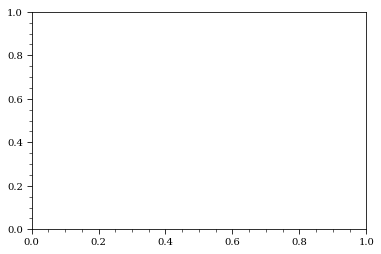

In [17]:
gc = GCRCatalogs.load_catalog('protoDC2')
quantities = gc.list_all_quantities()
test = ShearTest()
test.run_on_single_catalog( gc, 'protoDC2', './')